In [2]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 600

In [10]:
def read_PEs(csv_file):
    df = pd.read_csv(csv_file)
    
    return df["PE-A"].to_list()

def read_FITCs(csv_file):
    df = pd.read_csv(csv_file)
    return df["FITC-A"].to_list()

sample_list["PEs"] = sample_list.filename_expr.apply(read_PEs)
sample_list["FITCs"] = sample_list.filename_expr.apply(read_FITCs)
#sample_list["FITCs"] = sample_list.filename.apply(read_FITCs)
minPEs = sample_list.PEs.apply(np.min).min()
minFITCs = sample_list.FITCs.apply(np.min).min()
sample_list["logPEs"] = sample_list.PEs.apply(lambda x: [np.log10(u - minPEs + 1) for u in x])
sample_list["mean_log_PE"] = sample_list.logPEs.apply(np.mean)
sample_list["std_log_PE"] = sample_list.logPEs.apply(np.std)# / np.sqrt(df.PEs.apply(len))
sample_list["logFITCs"] = sample_list.FITCs.apply(lambda x: [np.log10(u - minFITCs + 1) for u in x])


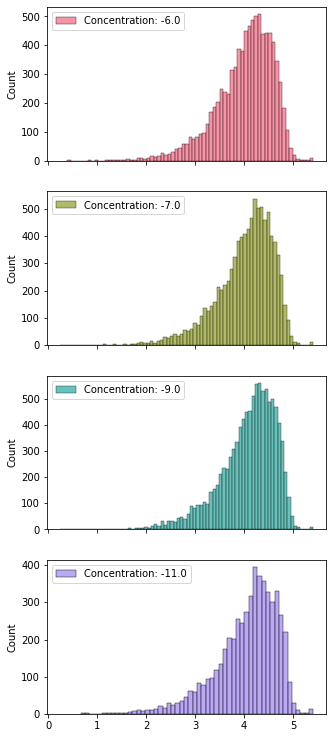

In [11]:
## expression 
df = sample_list[(sample_list.Strain == "LIB") &
                 (sample_list.Control == 0) &
                 (sample_list.Antibody == "REGN")]
fig, axes = plt.subplots(len(df), 1, figsize=(5, 13), sharex=True)
for ii, ((_, r), ax) in enumerate(zip(df.iterrows(), axes)):
    sns.histplot(r["logFITCs"], 
                 ax=ax,
                 label=f'Concentration: {r["log_concentration"]}',
                 color=sns.color_palette("husl", len(df))[ii])
    ax.legend()
plt.show()

In [12]:
def sigmoid(c, Kd, A, B):
    return  np.log10(A *(10**c/(10**c+10**Kd)) + B)

def rms(y, yfit):
    return np.sqrt(np.sum((y-yfit)**2))

def measure_Kds(mean_log_fluor, std_log_fluor, concs):
    popt, pcov = scipy.optimize.curve_fit(sigmoid,
                                          concs,
                                          mean_log_fluor,
                                          p0=[-9,10**4,10**1],
                                          sigma=std_log_fluor,
                                          absolute_sigma=True,
                                          bounds = [(-16,1,1),(-5,10**6,10**6)],
                                          maxfev=400000)

    return popt, pcov

    
def plot_fit(mean_log_fluor, std_log_fluor, concs, popt, pcov, ax):
    sns.set_style('whitegrid')
    concs_plot = np.linspace(concs.min(), concs.max())
    ax.errorbar(concs, mean_log_fluor, yerr=std_log_fluor, fmt='o', capsize=3)
    ax.plot(concs_plot, sigmoid(concs_plot, *popt), color='grey')
    ax.axvline(popt[0], linestyle='-', color='red',
               label=r'$\log_{10} K_D = %.2f \pm %.2f$' % (popt[0], pcov[0][0]))
    ax.axvline(popt[0] + pcov[0][0], linestyle=':', color='red')
    ax.axvline(popt[0] - pcov[0][0], linestyle=':', color='red')
    ax.set_xlabel('log [ACE]')
    ax.set_ylabel('log PE fluorescence')
    ax.legend()
    
# Similar to plot-fit but everything is exponentiated
def plot_fit_exp(mean_log_fluor, std_log_fluor, concs, popt, pcov, ax):
    sns.set_style('whitegrid')
    concs_plot = np.linspace(concs.min(), concs.max())
    ax.errorbar(concs, 10**mean_log_fluor, 
                yerr=np.stack((10**(mean_log_fluor - std_log_fluor), 10**(mean_log_fluor + std_log_fluor))),
                fmt='o', capsize=3)
    ax.plot(concs_plot, 10**sigmoid(concs_plot, *popt), color='grey')
    ax.axvline(popt[0], linestyle='-', color='red',
               label=r'$\log_{10} K_D = %.2f \pm %.2f$' % (popt[0], pcov[0][0]))
    ax.axvline(popt[0] + pcov[0][0], linestyle=':', color='red')
    ax.axvline(popt[0] - pcov[0][0], linestyle=':', color='red')
    ax.set_xlabel('log [ACE]')
    ax.set_ylabel('lPE fluorescence')
    ax.legend()

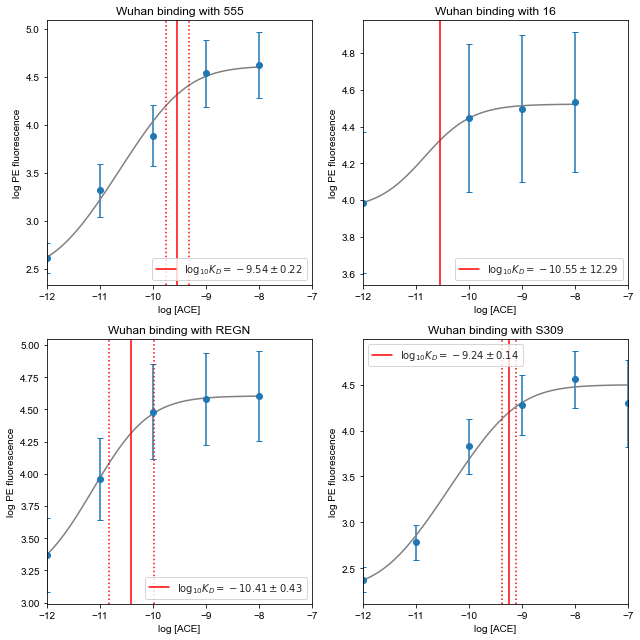

In [13]:

fig, axes = plt.subplots(2, 2, figsize=(9, 9))
for ab, ax in zip(sample_list.Antibody.unique(), axes.flatten()):
    df = sample_list[(sample_list.Strain == "102") 
                     & (sample_list.Control == 0) 
                     & (sample_list.Antibody == ab)
                     & (sample_list.is_bad != 1)]
    df = df[df.Sample != "F3"]
    popt, pcov = measure_Kds(df.mean_log_PE, df.std_log_PE, df.log_concentration)
    plot_fit(df.mean_log_PE, df.std_log_PE, df.log_concentration, popt, pcov, ax)
    ax.set_title(f"Wuhan binding with {ab}")
    ax.set_xlim((-12, -7))
plt.tight_layout()

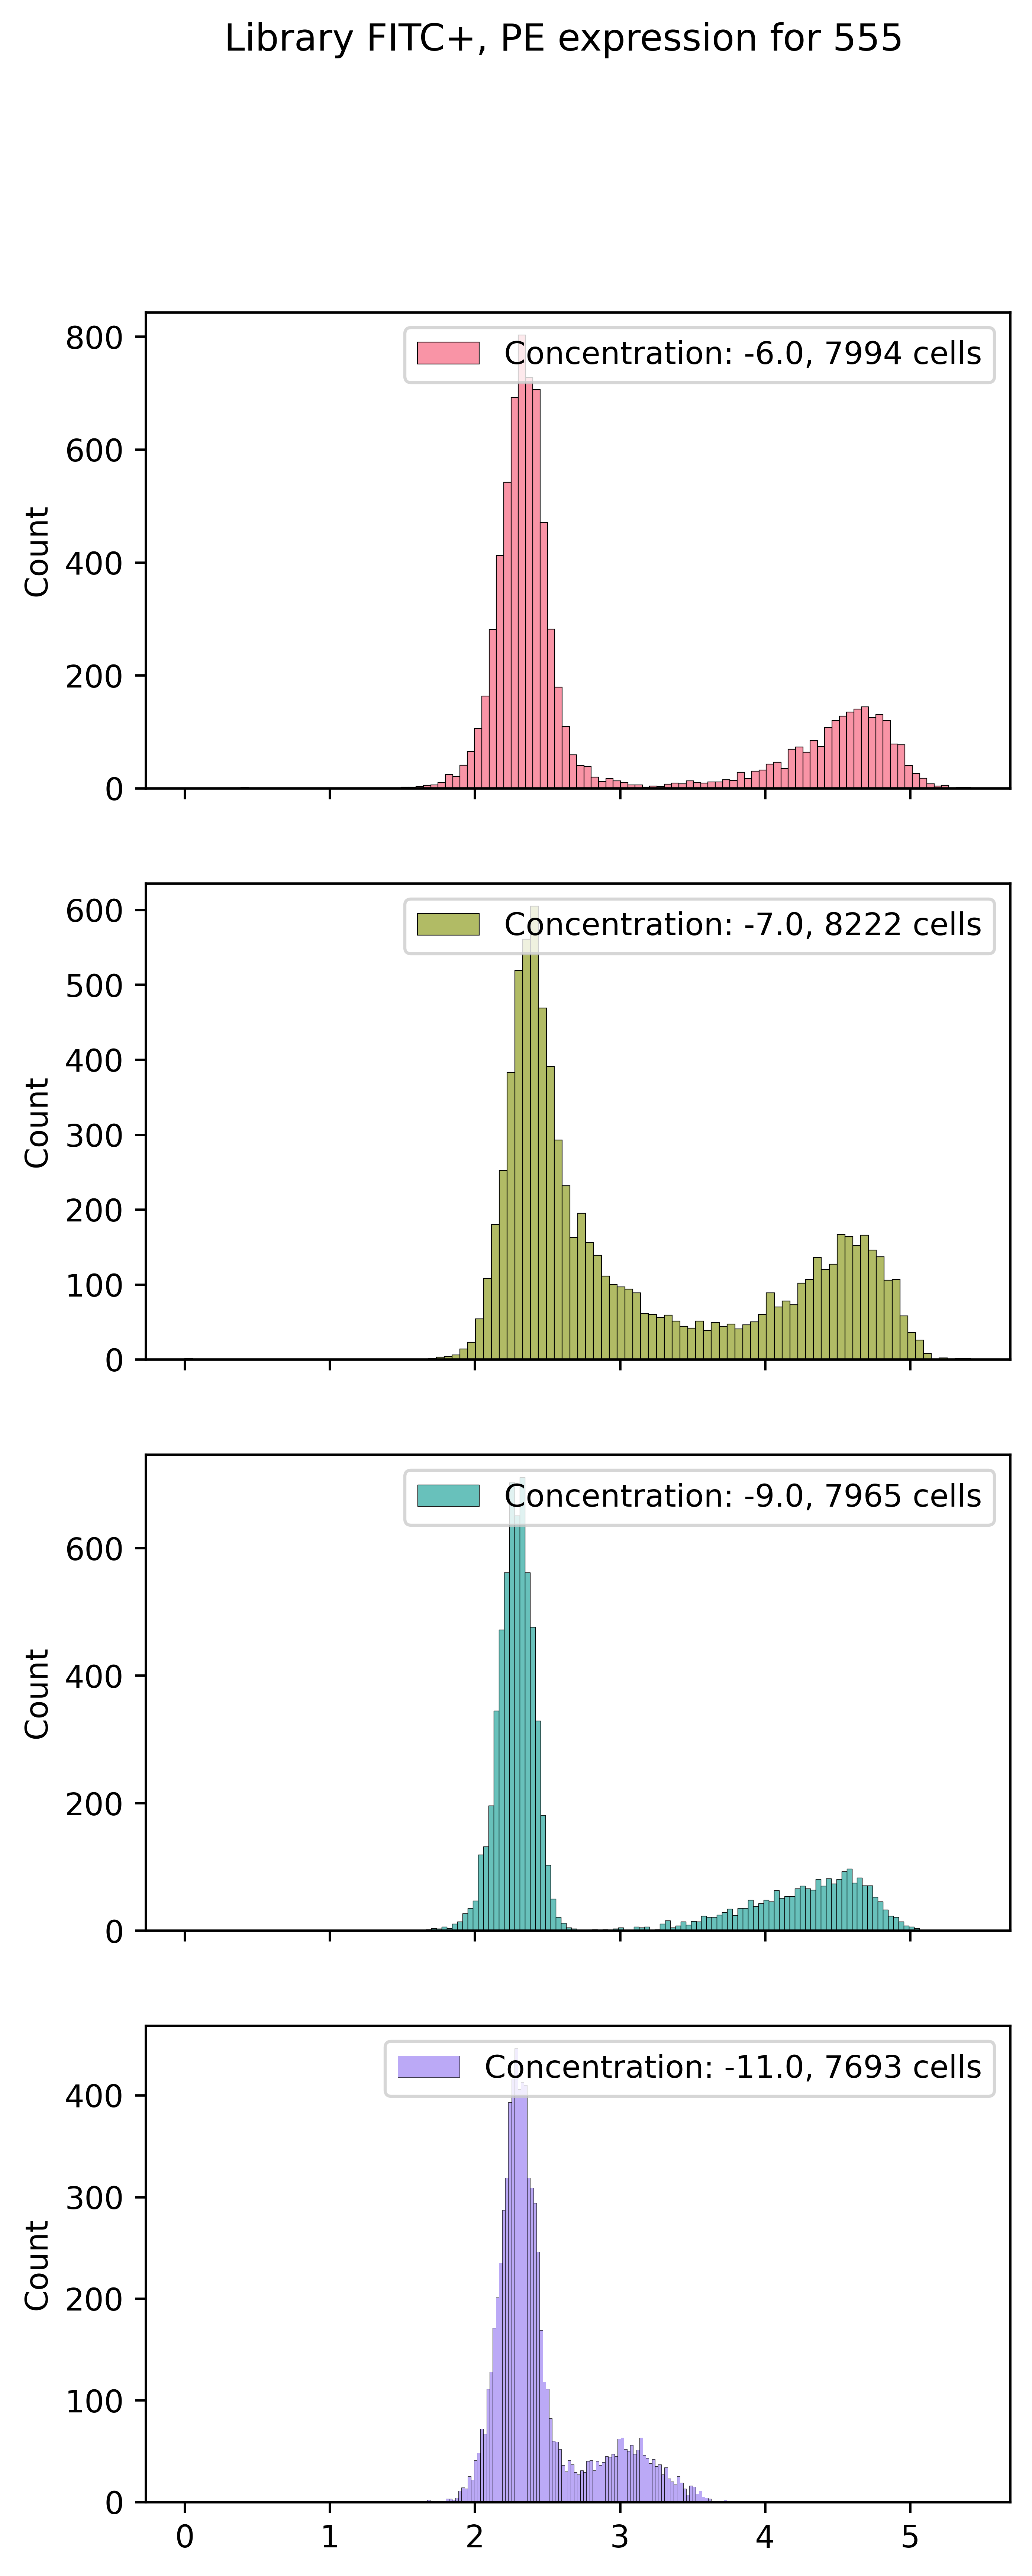

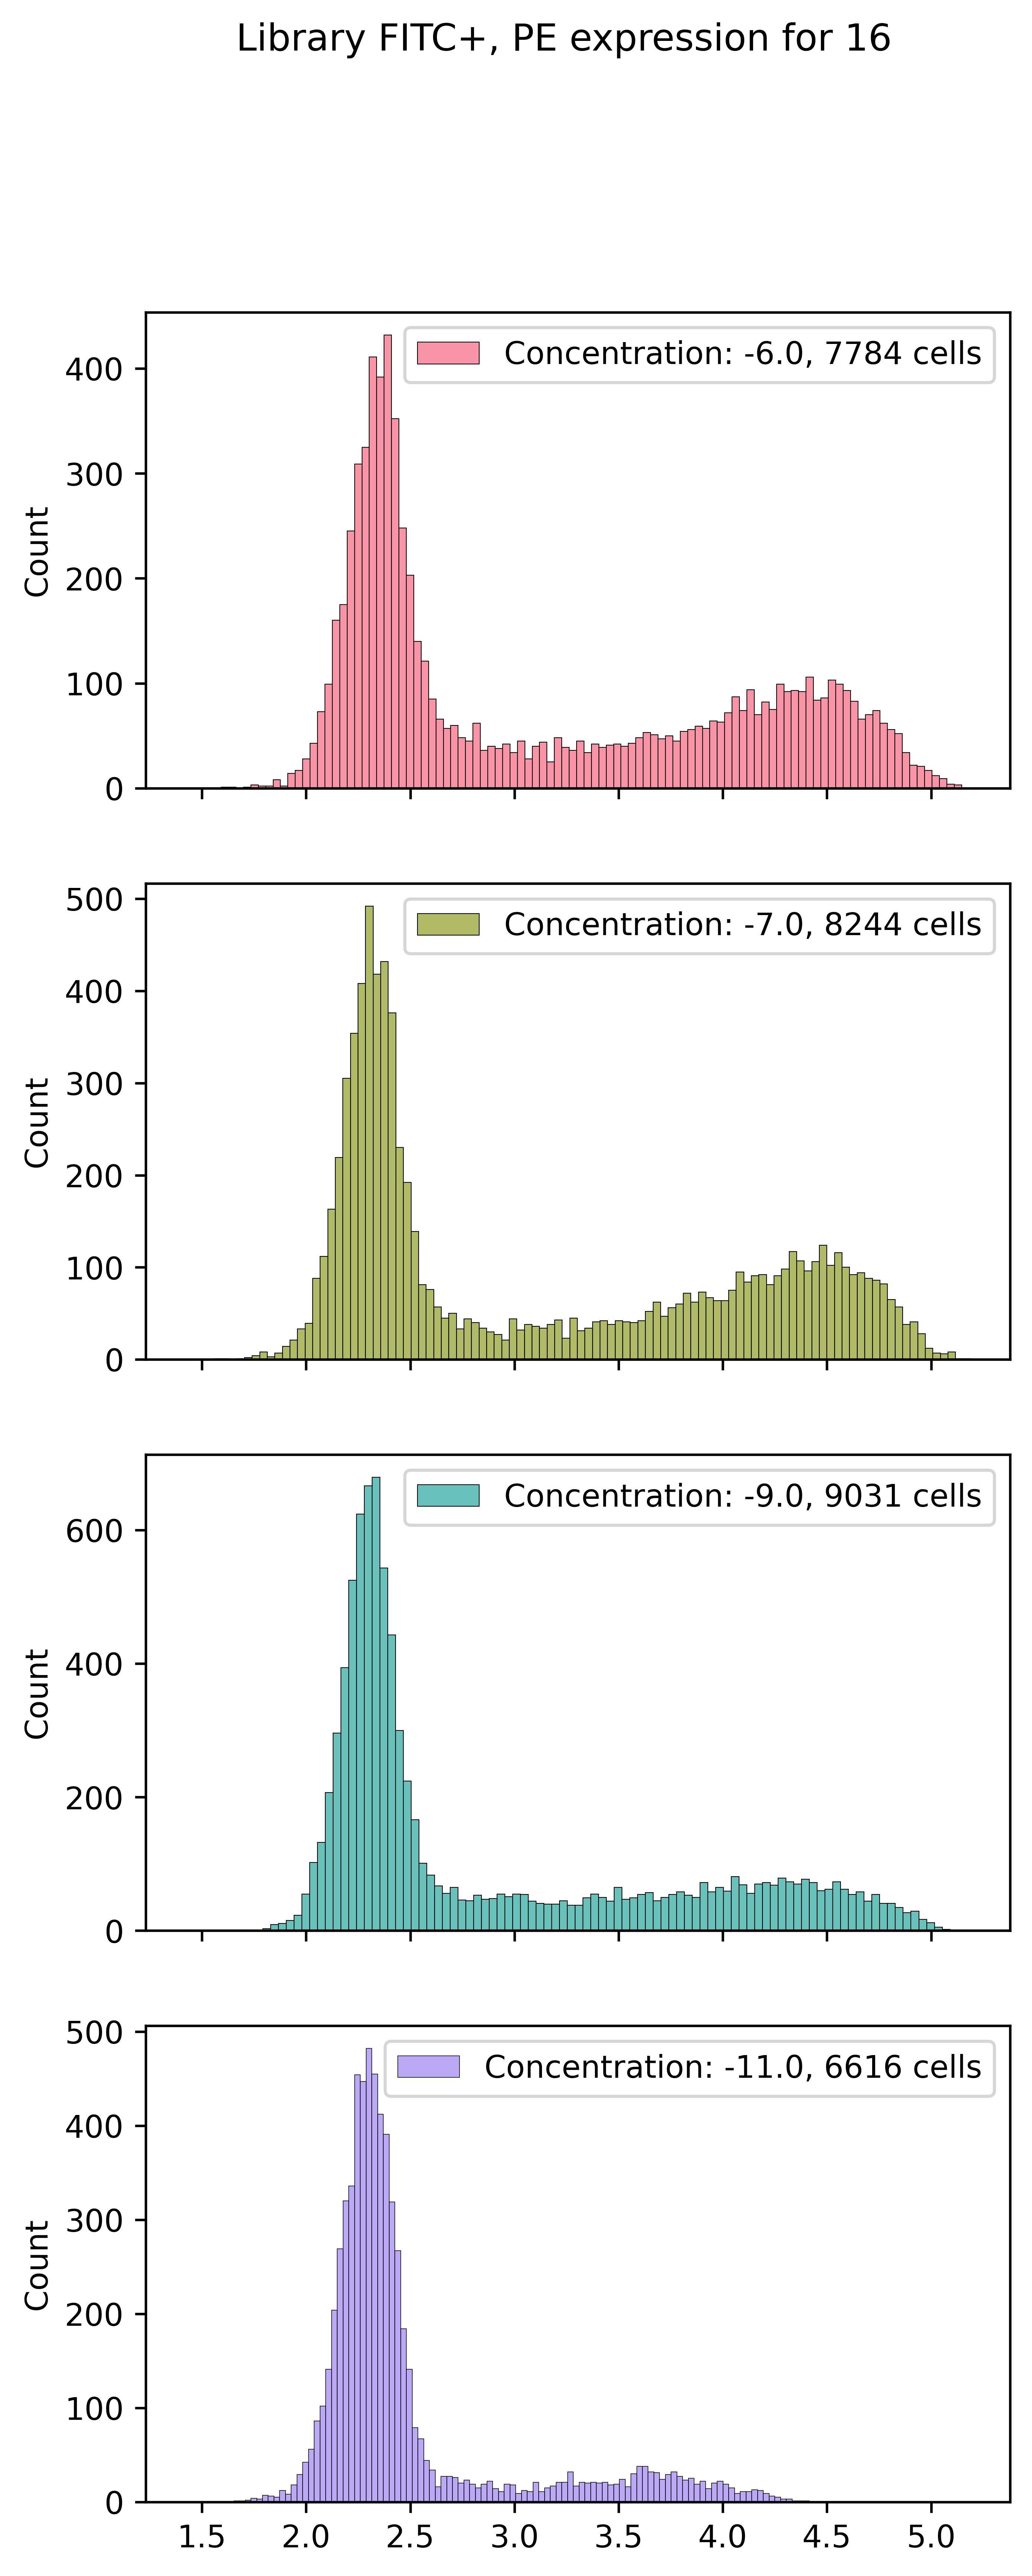

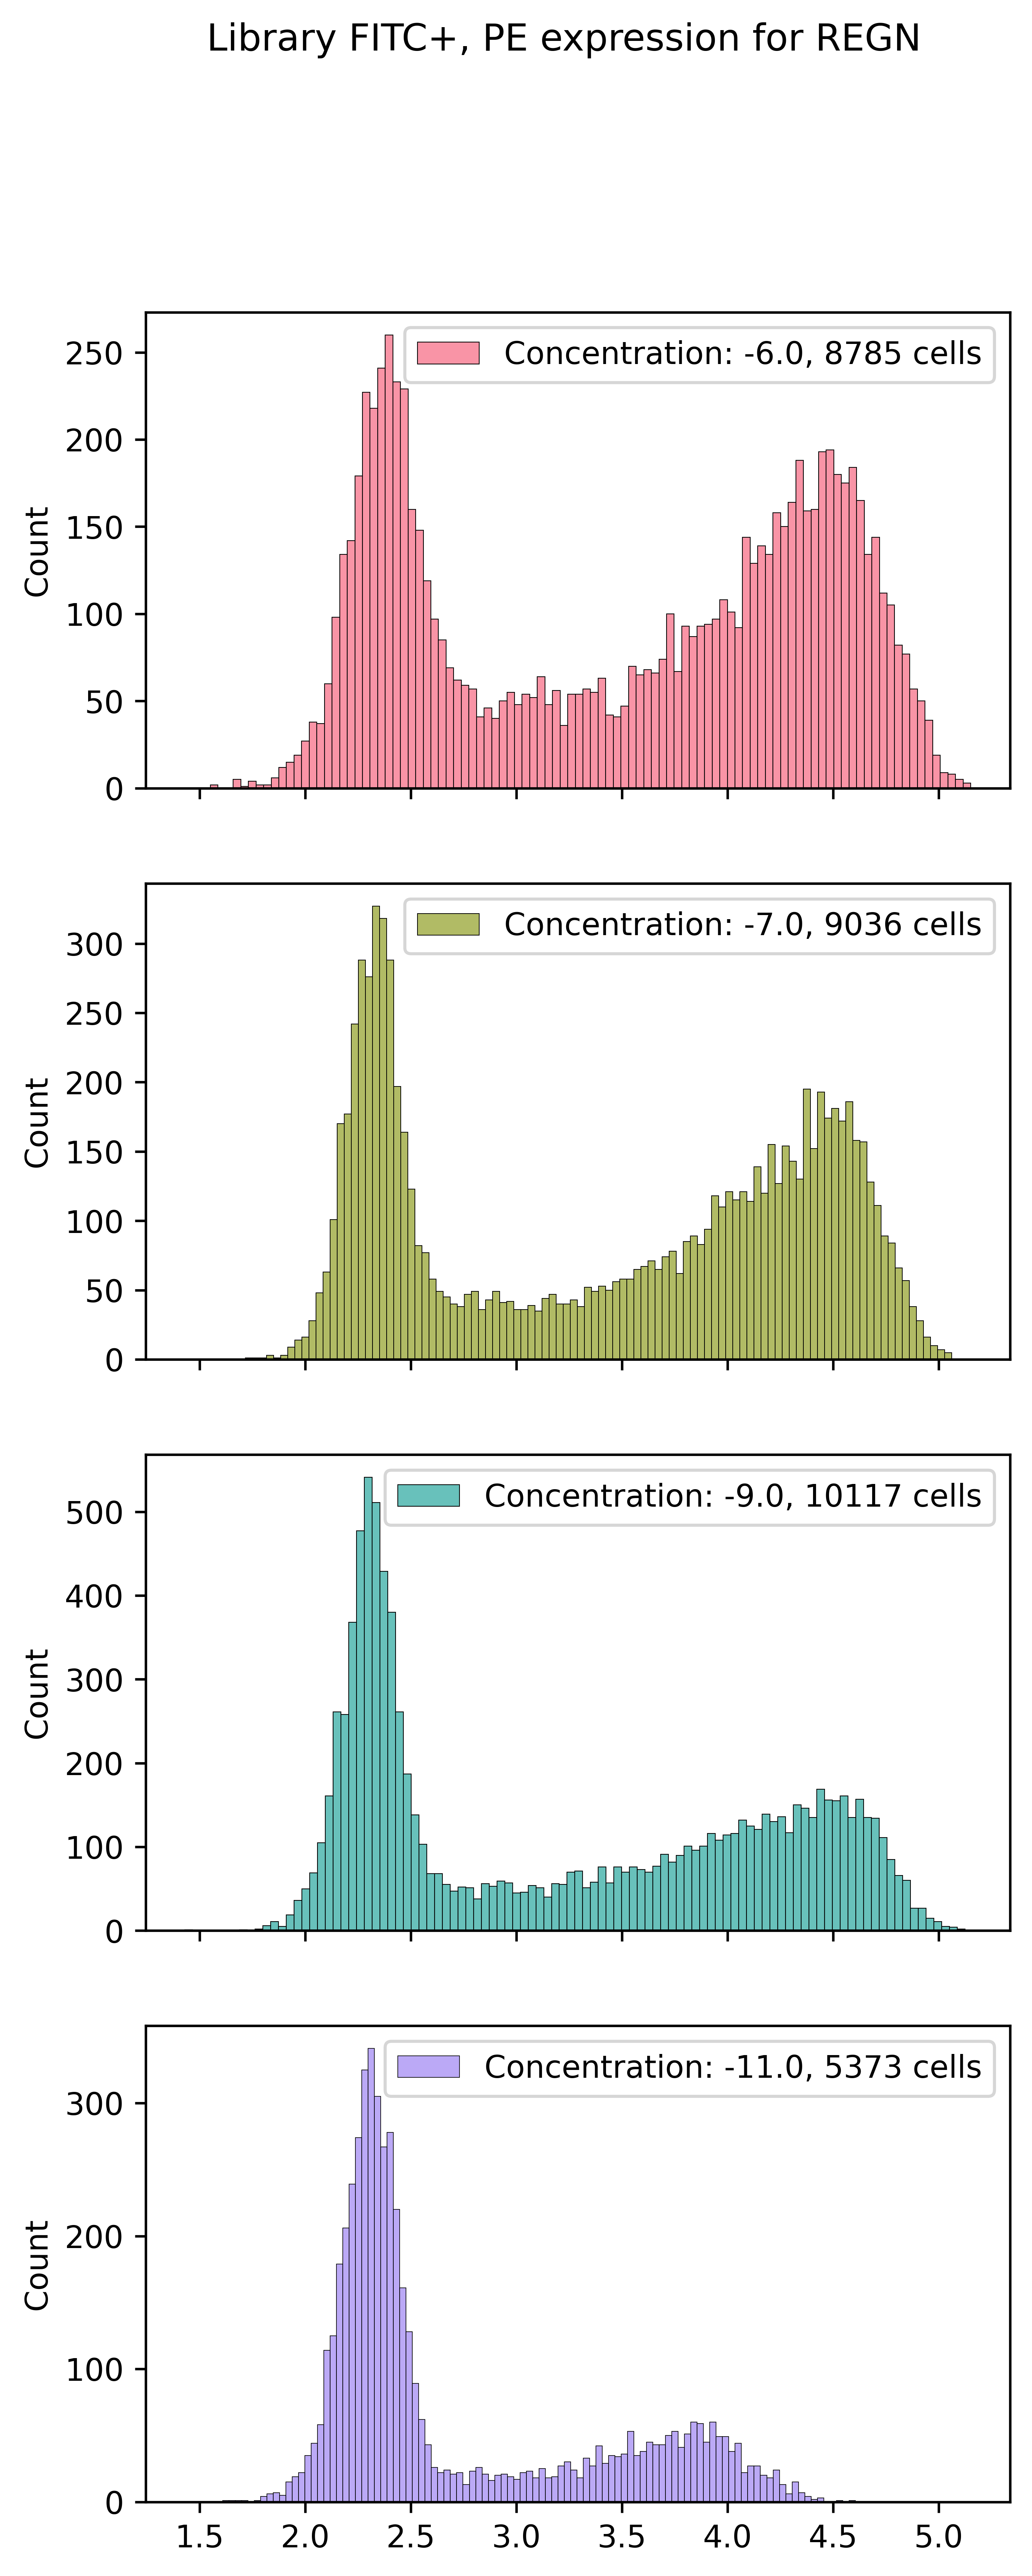

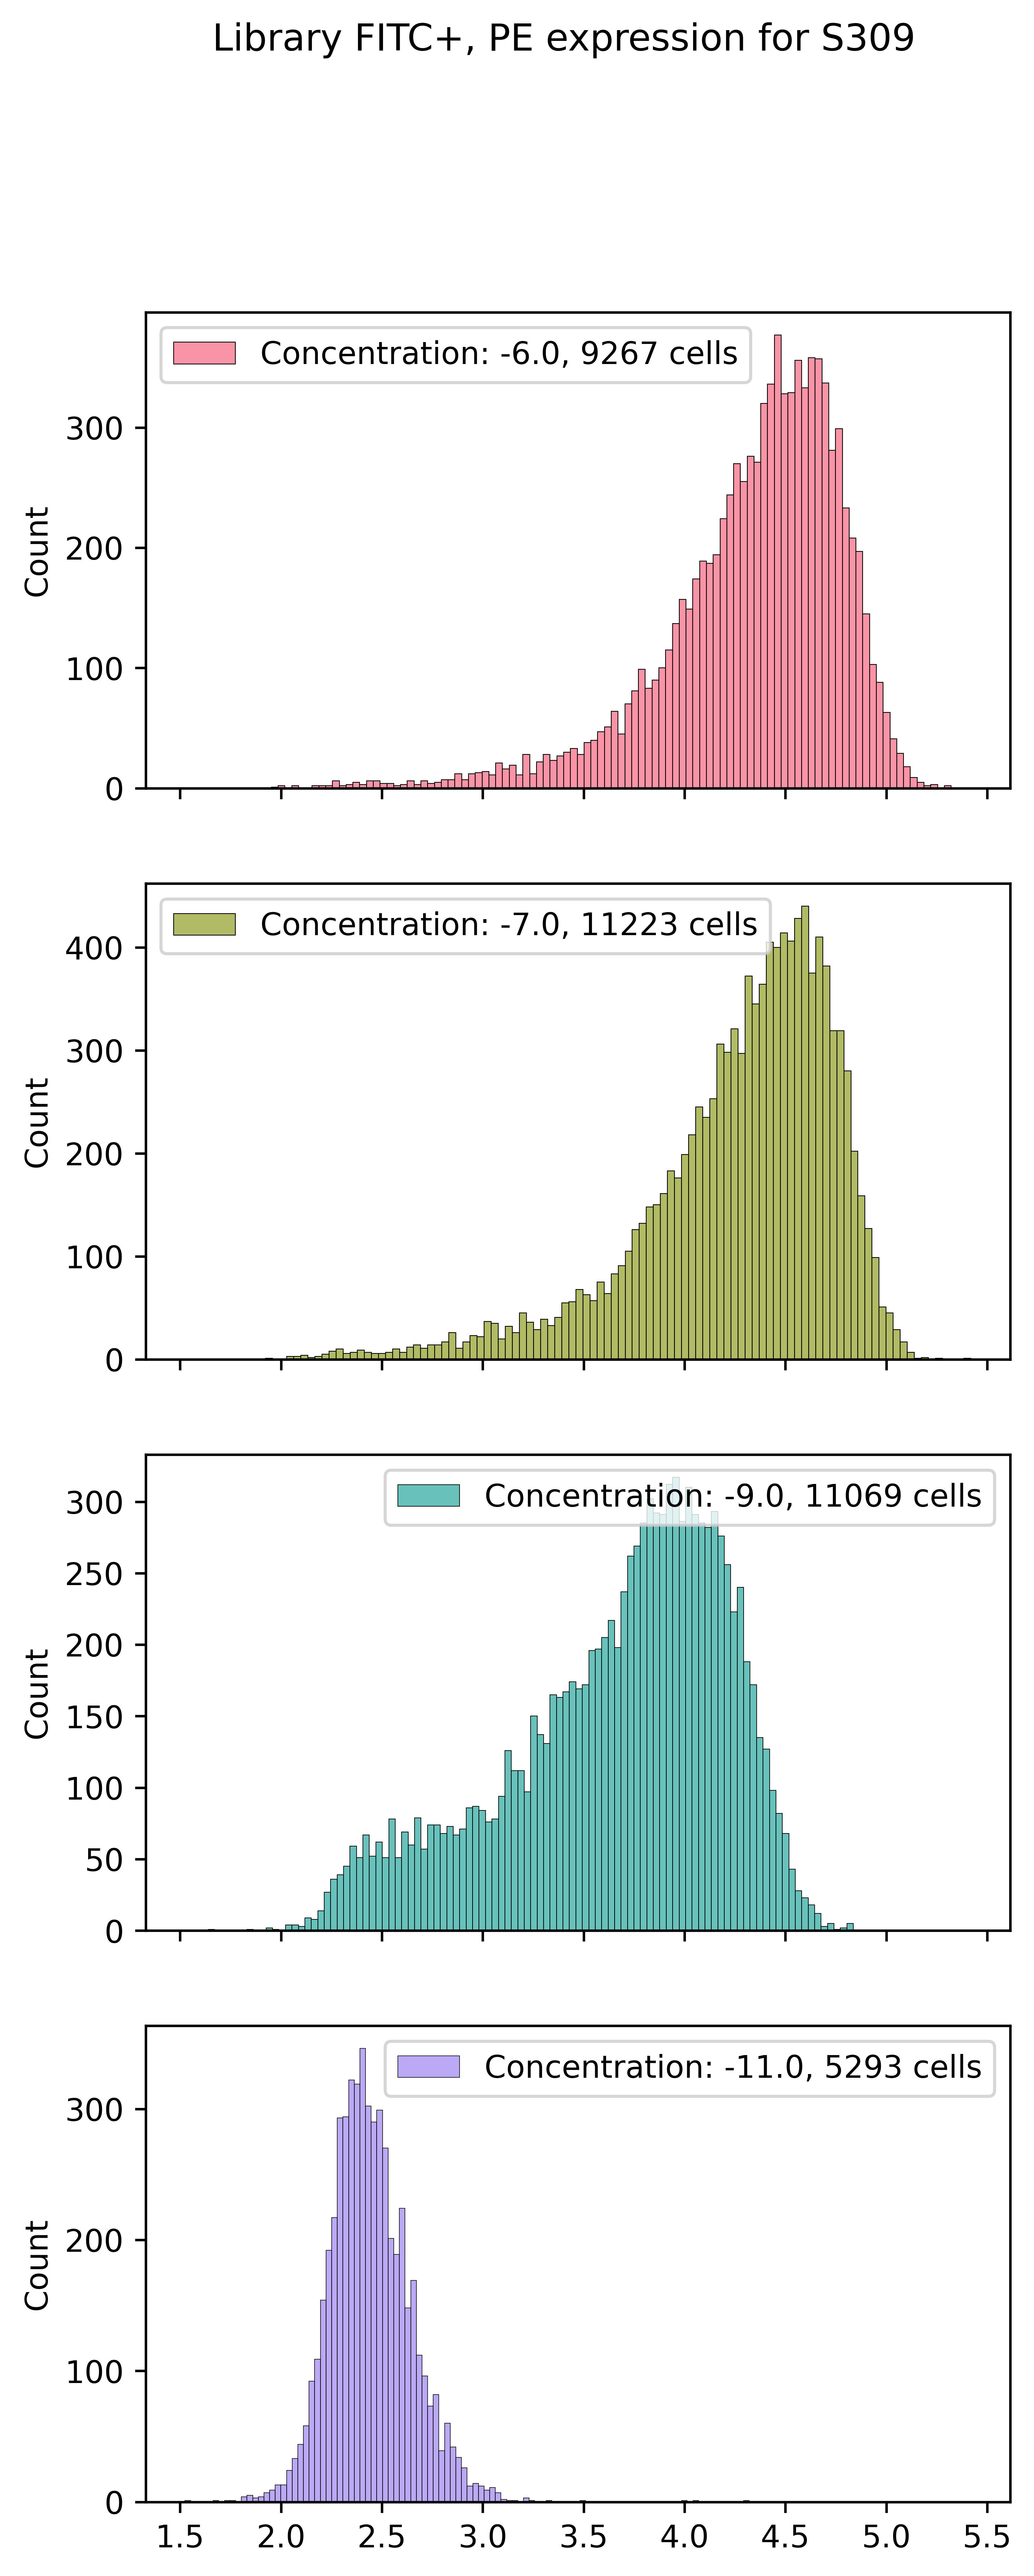

In [5]:
for ab in sample_list.Antibody.dropna().unique():
    ## expression 
    df = sample_list[(sample_list.Strain == "LIB") &
                     (sample_list.Control == 0) &
                     (sample_list.Antibody == ab)]
    fig, axes = plt.subplots(len(df), 1, figsize=(5, 13), sharex=True)
    for ii, ((_, r), ax) in enumerate(zip(df.iterrows(), axes)):
        sns.histplot(r["logPEs"], 
                     ax=ax,
                     label=f'Concentration: {r["log_concentration"]}, {len(r["logPEs"])} cells',
                     color=sns.color_palette("husl", len(df))[ii], bins=100)
        ax.legend()
    fig.suptitle(f"Library FITC+, PE expression for {ab}")
plt.show()

In [14]:
sample_list[sample_list.Strain == "LIB"]

,Sample,log_concentration,Strain,Antibody,Control,is_bad,filename,filename_expr,PEs,FITCs,logPEs,mean_log_PE,std_log_PE,logFITCs
24,E1,-6.0,LIB,555,0,0,../../Additional_data/Isogenic_measurement/202...,../../Additional_data/Isogenic_measurement/202...,"[118.8, 18.72, 53497.4, 190.8, -15.12, -13.68,...","[35148.2, 30829.7, 21303.4, 72493.2, 1844.64, ...","[2.48815572376571, 2.3173110202068115, 4.72986...",2.906626,0.983512,"[4.527674230152427, 4.468124808281811, 4.29794..."
25,E2,-7.0,LIB,555,0,0,../../Additional_data/Isogenic_measurement/202...,../../Additional_data/Isogenic_measurement/202...,"[62529.8, 28952.6, 812.88, -35.28, 12902.4, 11...","[26691.8, 25540.6, 5141.52, 55805.0, 30685.0, ...","[4.7973971864332485, 4.464512200501793, 3.0007...",3.130317,0.940571,"[4.40221046811721, 4.381942070749532, 3.567821..."
26,E4,-9.0,LIB,555,0,0,../../Additional_data/Isogenic_measurement/202...,../../Additional_data/Isogenic_measurement/202...,"[6.48, 4443.84, -21.6, 64.08, -12.24, -15.84, ...","[7115.76, 10026.7, 6425.28, 6408.0, 30520.1, 3...","[2.2909245593827543, 3.6658398021726257, 2.223...",2.822767,0.921271,"[3.753659647285999, 3.933585473869456, 3.69727..."
27,E6,-11.0,LIB,555,0,0,../../Additional_data/Isogenic_measurement/202...,../../Additional_data/Isogenic_measurement/202...,"[10.08, 86.4, -4.32, 52.56, 51.84, 1.44, 766.8...","[80747.3, 17492.4, 262143.0, 41678.6, 28622.2,...","[2.298853076409707, 2.4398377608816957, 2.2662...",2.446473,0.340940,"[4.899287097662093, 4.205411173168421, 5.41613..."
28,F1,-6.0,LIB,16,0,0,../../Additional_data/Isogenic_measurement/202...,../../Additional_data/Isogenic_measurement/202...,"[43351.9, 18.72, 115.92, -15.12, 21352.3, 3135...","[12973.7, 4903.92, 1540.8, 49444.6, 14832.0, 1...","[4.63889660380755, 2.3173110202068115, 2.48407...",3.132735,0.930258,"[4.061789378993472, 3.538970650337591, 1.98245..."
29,F2,-7.0,LIB,16,0,0,../../Additional_data/Isogenic_measurement/202...,../../Additional_data/Isogenic_measurement/202...,"[10.08, 19.44, 29466.7, 50.4, 106.56, 64529.3,...","[25922.2, 11821.7, 23944.3, 61598.2, 6568.56, ...","[2.298853076409707, 2.3188143487606596, 4.4721...",3.133994,0.963260,"[4.3887659946822355, 4.016069305628285, 4.3521..."
30,F4,-9.0,LIB,16,0,0,../../Additional_data/Isogenic_measurement/202...,../../Additional_data/Isogenic_measurement/202...,"[63.36, 16.56, 66217.7, -33.12, -75.6, 30420.7...","[48643.9, 9904.32, 38903.8, 96379.9, 1928.88, ...","[2.4018828223212823, 2.3127695570522997, 4.822...",2.875189,0.846264,"[4.67393408556932, 3.9273477750317607, 4.57355..."
31,F6,-11.0,LIB,16,0,0,../../Additional_data/Isogenic_measurement/202...,../../Additional_data/Isogenic_measurement/202...,"[128.88, 154.8, 3775.68, -54.0, 5427.36, -18.7...","[2506.32, 5811.84, 28926.7, 24760.1, 19579.0, ...","[2.5021538928713607, 2.5362048031204396, 3.598...",2.496084,0.491737,"[3.025944545777103, 3.640191147781271, 4.43904..."
32,G1,-6.0,LIB,REGN,0,0,../../Additional_data/Isogenic_measurement/202...,../../Additional_data/Isogenic_measurement/202...,"[13.68, 312.48, 6306.48, 40.32, 24488.6, -17.2...","[33708.2, 4265.28, 8817.12, 9958.32, 14870.9, ...","[2.3066394410242617, 2.7001843296221977, 3.812...",3.508087,0.934866,"[4.508710670968924, 3.450329183607182, 3.86760..."
33,G2,-7.0,LIB,REGN,0,0,../../Additional_data/Isogenic_measurement/202...,../../Additional_data/Isogenic_measurement/202...,"[7724.16, 35544.2, 211.68, 53.28, 539.28, 4368...","[7223.04, 19411.9, 3538.08, 1783.44, 13978.1, ...","[3.898345556398927, 4.553070937826472, 2.60271...",3.453990,0.942726,"[3.7617985827675446, 4.254478951840749, 3.3208..."
